Paper Main Idea:

Activations are hard to quantize because outliers stretch the quantization range, leaving few effective bits for most values. SmoothQuant overcomes this problem by migrating the scale invariance from activations to weights during the offline phase to reduce the quantization difficulty originating from activations.

The smoothed activations and weights are then easy to quantize.

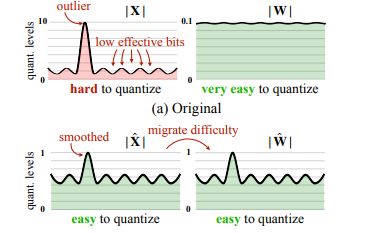

In [1]:
import numpy as np

def smooth_quant(X, W, alpha=0.5):

  """
  The author find that α = 0.5 is a well-balanced point to evenly split the quantization difficulty

  """

    # Calculate per-channel smoothing factor s
    max_X = np.max(np.abs(X), axis=0)
    max_W = np.max(np.abs(W), axis=1)

    # The formula ensures that the W and X share a similar maximum value and quantization difficulty. 
    s = np.power(max_X, alpha) / np.power(max_W, 1 - alpha)
    
    # Smooth the input activation
    X_hat = np.power(X * np.diag(s), -1)
    
    # Scale the weights accordingly to keep the mathematical equivalence of a linear layer
    W_hat = np.diag(s) * W

    Y = X_hat @ W_hat
    
    return X_hat, W_hat

def smooth_quant_transformer_block(X, W, alpha):
    # Apply scale smoothing to the input activations
    X_hat, W = smooth_quant(X, W, alpha)
    
    # Quantize linear layers with W8A8
    W_quantized = quantize_weights(W, 8)
    
    # Quantize BMM operators in the attention computation
    # (assuming BMM is a separate function)
    BMM_quantized = quantize_bmm(X_hat, W_quantized)
    
    return X_hat, W_quantized, BMM_quantized

def quantize_weights(W, num_bits=8):
    # Calculate the quantization range
    delta = np.max(np.abs(W))
    c = (2 ** (num_bits - 1) - 1)

    scale = delta / c

    W_quantized = np.round(W / scale)
    
    return W_quantized


# Example usage
X = np.random.randn(10, 5)  # Input activations
W = np.random.randn(5, 3)  # Weight matrix
alpha = 0.5  # Migration strength

X_hat, W_hat, BMM_quantized = smooth_quant_transformer_block(X, W, alpha)